THIS FILE SHOWCASES ALL FEATURE IN THE DATASET.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import shap
#from shap.plots import *
df = pd.read_csv('train.csv')




# get all numeric features already present
numbers_col = df.select_dtypes(include = ['float64', 'int64'])

# convert the rest into numeric
for x in df:
  if x not in numbers_col:
    df[x] = df[x].astype('category')
    df[x] = df[x].cat.codes
   
# merge into a single df
frames = [numbers_col, df]
finaldf = pd.concat(frames)
#print(numbers_col)
#print(df)
#print(finaldf.isna())
finaldf = finaldf.dropna()
#display(finaldf)

X = finaldf.drop(columns = 'SalePrice') #Training features


y= finaldf['SalePrice'] #Sale price
#train model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
lr = LinearRegression()
model = lr.fit(X_train,y_train)

c = lr.intercept_ #debug
m = lr.coef_ #debug
y_pred_train = lr.predict(X_train)
a= lr.predict(X_test)
feature_coef = {}
# get coef of each features, add it to list
for x in range(lr.n_features_in_):

  name = lr.feature_names_in_[x]
  coef = lr.coef_[x]
  
  feature_coef[name] = coef
  
# sort the dictionnary higher to lower coef
feature_coef_sorted = sorted(feature_coef.items(), key=lambda x:x[1], reverse = True)
print("############## COEF VALUES WHEN USING LINEAR REGRESSION ALGORITHM ##############")
print(*feature_coef_sorted, sep="\n")
##r2_score(y_train, y_pred_train)

#initalize sharp interpretation
explainer = shap.Explainer(lr.predict, X)
shap_values = explainer(X)
#shap.plots.bar(shap_values)

#shap.initjs()
#shap.plots.force(shap_values[0])

c:\Users\blood\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


############## COEF VALUES WHEN USING LINEAR REGRESSION ALGORITHM ##############
('Street', 46449.92999006201)
('OverallQual', 10578.880640836467)
('Fireplaces', 9426.434000759895)
('GarageCars', 7755.623722720324)
('RoofMatl', 5969.364322861658)
('LandSlope', 5944.299668165772)
('OverallCond', 4687.460244348753)
('Functional', 4448.146526264201)
('TotRmsAbvGrd', 4382.473233216231)
('FullBath', 3953.774295010033)
('GarageCond', 3686.3673103176257)
('MasVnrType', 3678.247444001552)
('SaleCondition', 3617.130253320477)
('Foundation', 3013.6179332146457)
('MiscFeature', 1984.4885926297334)
('PavedDrive', 1820.4953806716744)
('BsmtHalfBath', 1819.8587938503597)
('BsmtFullBath', 1766.9399132309263)
('HalfBath', 1608.9119049512656)
('GarageType', 1575.3035326037852)
('BsmtCond', 1310.5484862938856)
('LandContour', 1298.4774482675584)
('BsmtFinType2', 1269.6228633527953)
('RoofStyle', 907.2933343435643)
('Neighborhood', 683.6670611523141)
('PoolArea', 599.2854282339522)
('MSZoning', 302.46602

Permutation explainer: 1122it [00:18, 31.30it/s]                          


Overall we can see by this printed out list the the street and overallqual seems to dominate the influence over the house pricing. 

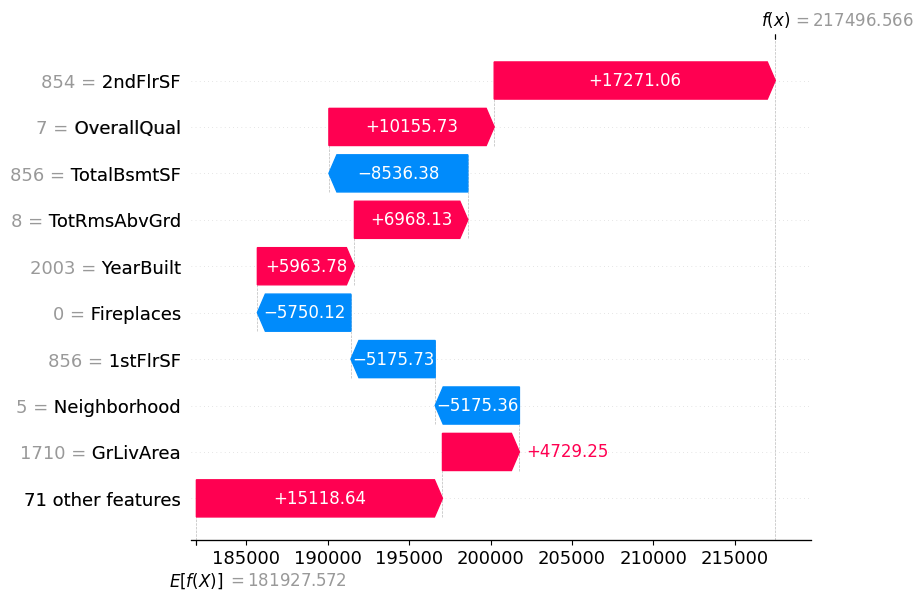

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


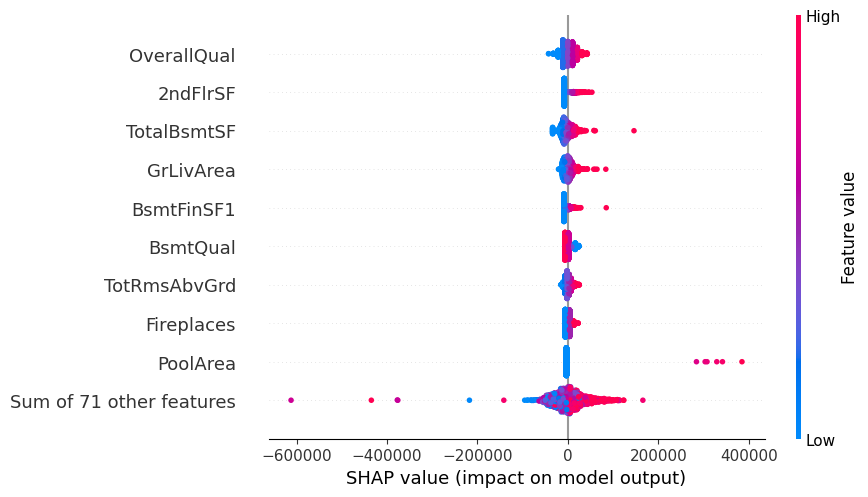

In [6]:
shap.plots.waterfall(shap_values[0]) #edit index if you wish to see other predictions
shap.plots.beeswarm(shap_values)
shap.initjs()
shap.plots.force(shap_values)

However, using the SHAP method, to get the TRUE value of each feature, we realize that the GrLivArea,OverallQual 2ndFlrSF and totalBsmtSF seem to be influencing house pricing the most.
While feature influence may vary according to every test houses, it is important to notice some patterns.
In summary:
The SHAP analysis of the set allowed us to determine the most infuencial feature of our set. We can see a clear difference between the coefficient of the linear regression model and the coefficients of the SHAP value interpretation. This highlight the importance to assess our model with tools such as SHAP.


In [3]:
import lightgbm as lgb
import sklearn
import optuna.integration.lightgbm as lgb_opt
from sklearn.metrics import mean_squared_error
import numpy as np
import optuna
# USING LIGHTGBM



d_train = lgb.Dataset(X_train, label=y_train)
lgbm_params = {'learning_rate':0.05, 'boosting_type': 'gbdt',
               'objective':'regression',
               'verbose': -1
               }

clf_lgb = lgb.train(lgbm_params,d_train) # train the data with lightGBM

y_pred_lgbm = clf_lgb.predict(X_test)


explainer = shap.Explainer(clf_lgb.predict, X) # sharp interpretation value

shap_values = explainer(X)


#boosting parameters with optuna


def objective(trial):
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 10,3000),
        'max_depth': trial.suggest_int('max_depth', 3,12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        'verbose': -1
    }
 
    clf_lgb = lgb.train(param,d_train)
    y_pred = clf_lgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100)


print(study.best_params) ## optimal parameters
param = study.best_params
param["verbose"] = -1

clf_opt = lgb.train(param,d_train)
y_pred = clf_opt.predict(X_test)

explainer_opt = shap.Explainer(clf_opt.predict, X) # sharp interpretation value
shap_values_opt = explainer_opt(X)








Permutation explainer: 1122it [01:00, 15.58it/s]                          


{'learning_rate': 0.21321379732737097, 'num_leaves': 2161, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 60, 'lambda_l2': 10, 'min_gain_to_split': 10.002145991238882}


Permutation explainer: 1122it [00:43, 19.67it/s]                          


before tuning with optuna


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


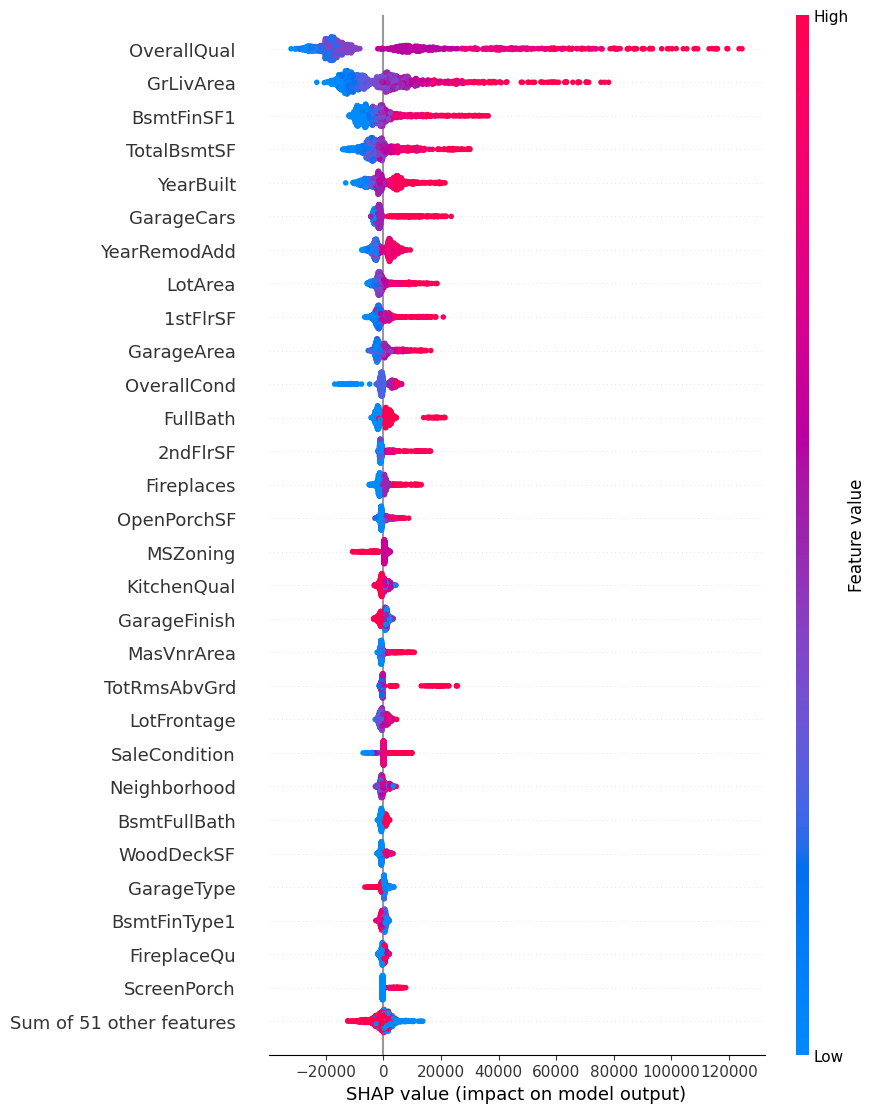

after tuning with optuna


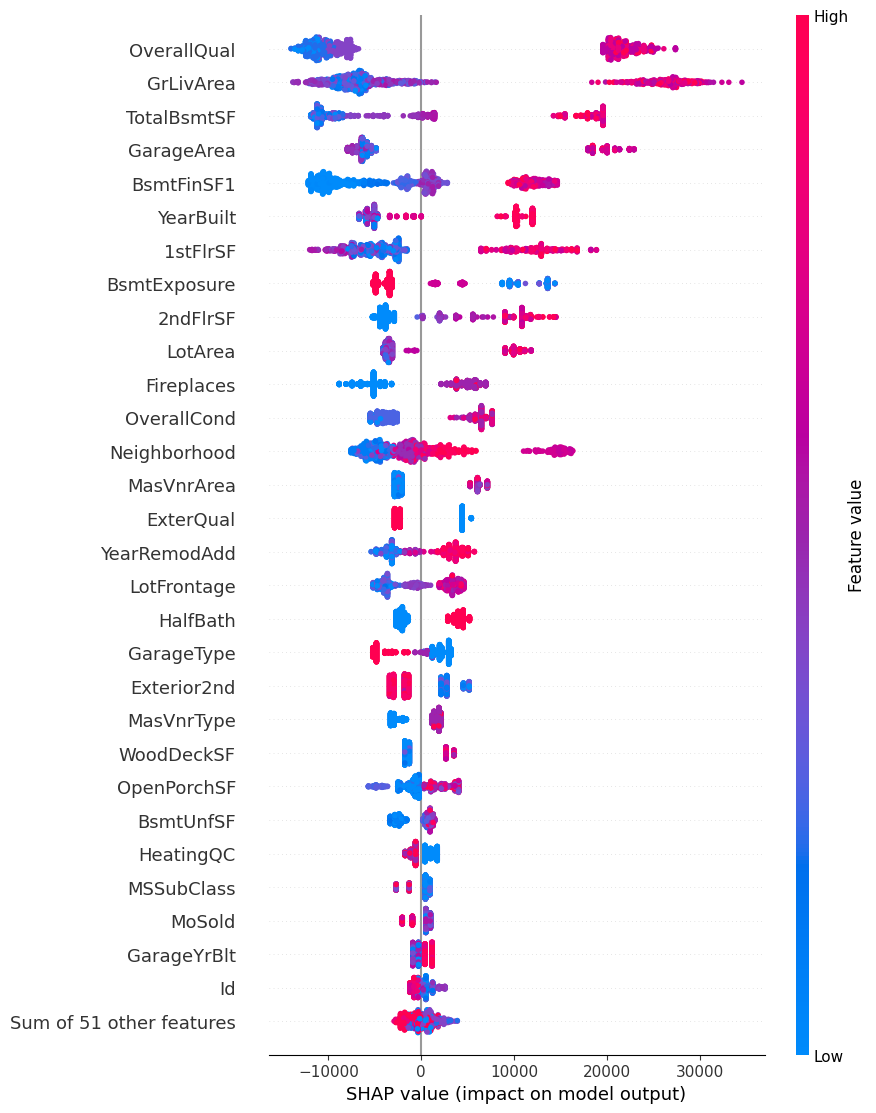

In [5]:


print("before tuning with optuna")
shap.plots.beeswarm(shap_values, max_display=30)

print("after tuning with optuna")
shap.plots.beeswarm(shap_values_opt, max_display=30)